In [1]:
#Librería para plotear en 3D
from mpl_toolkits.mplot3d import Axes3D

#Incluímos las librerías que vamos a usar
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, sys

In [2]:
class domain:
    #El constructor se encarga de hacer el preprocesamiento
    def __init__(self, Lx, Ly, T, v, dx, dy, dt):       
        self.Nx = int(Lx/dx)                      #Número de puntos desde 0 hasta Nx
        self.x = np.linspace(0, Lx, self.Nx+1)    #Creo un vector que va desde el 0 hasta Lx con Nx+1 divisiones
        self.dx = self.x[1]-self.x[0]             #Chequeo del dx, para que coincida
        
        self.Ny = int(Ly/dy)                      #Número de puntos desde 0 hasta Ny
        self.y = np.linspace(0, Ly, self.Ny+1)    #Creo un vector que va desde el 0 hasta Ly con Ny+1 divisiones
        self.dy = self.y[1]-self.y[0]             #Chequeo del dy, para que coincida

        self.Nt = int(T/dt)                       #Número de puntos desde 0 hasta Nt
        self.t = np.linspace(0, T, self.Nt+1)     #Creo un vector que va desde el 0 hasta T con Nt+1 divisiones
        self.dt = self.t[1]-self.t[0]             #Chequeo del dt, para que coincida

        self.alfa = v*self.dt/self.dx**2          #Número adimensional difusión en X
        self.beta = v*self.dt/self.dy**2          #Número adimensional difusión en Y

        self.cx = self.dt/self.dx                 #Número adimensional advección en X
        self.cy = self.dt/self.dy                 #Número adimensional advección en Y
        
        #Creamos dos matrices: una representa el tiempo presente y la otra el tiempo futuro
        self.u2 = np.zeros((self.Nx+1, self.Ny+1))
        self.u1 = np.zeros((self.Nx+1, self.Ny+1))
        self.v2 = np.zeros((self.Nx+1, self.Ny+1))
        self.v1 = np.zeros((self.Nx+1, self.Ny+1))

    #En este método incluimos la condición inicial para t=0 en todo el dominio x,y
    def initialCond(self):
        #Añadimos la condición inicial en la posicón del presente
        self.u1[int(0.7/self.dx):int(1/self.dx), int(0.7/self.dy):int(1/self.dy)] = 1.5
        self.v1[int(0.7/self.dx):int(1/self.dx), int(0.7/self.dy):int(1/self.dy)] = 1.5
        
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.MAG = np.sqrt(self.u1**2 + self.v1**2)
        fig, ax = plt.subplots(1,1)
        result = ax.contourf(self.X, self.Y, self.MAG, cmap = 'coolwarm')
        fig.colorbar(result)
        ax.set_title('Simulation at t={:.2f}'.format(self.t[0]))
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')

    def solver(self):
        for n in range(1, self.Nt):
            self.u2[1:-1,1:-1] = self.u1[1:-1,1:-1] - self.cx*self.u1[1:-1,1:-1]*(self.u1[1:-1, 1:-1] - self.u1[1:-1, :-2]) - \
                                 self.cy*self.v1[1:-1, 1:-1]*(self.u1[1:-1,1:-1] - self.u1[:-2,1:-1]) + \
                                 self.alfa*(self.u1[1:-1, 2:] - 2*self.u1[1:-1, 1:-1] + self.u1[1:-1, :-2]) + \
                                 self.beta*(self.u1[2:, 1:-1] - 2*self.u1[1:-1, 1:-1] + self.u1[:-2, 1:-1])
            
            self.v2[1:-1,1:-1] = self.u1[1:-1,1:-1] - self.cx*self.u1[1:-1,1:-1]*(self.v1[1:-1, 1:-1] - self.v1[1:-1, :-2]) - \
                                 self.cy*self.v1[1:-1, 1:-1]*(self.v1[1:-1,1:-1] - self.v1[:-2,1:-1]) + \
                                 self.alfa*(self.v1[1:-1, 2:] - 2*self.v1[1:-1, 1:-1] + self.v1[1:-1, :-2]) + \
                                 self.beta*(self.v1[2:, 1:-1] - 2*self.v1[1:-1, 1:-1] + self.v1[:-2, 1:-1])
            
            #Definimos los valores de la frontera
            self.u2[:, 0] = 0   #Para todas las filas, columna 0
            self.u2[:, -1] = 0  #Para todas las filas, última columna
            self.u2[0, :] = 0   #Para todas las columnas, fila 0
            self.u2[-1, :] = 0  #Para todas las columnas, última fila

            self.v2[:, 0] = 0   #Para todas las filas, columna 0
            self.v2[:, -1] = 0  #Para todas las filas, última columna
            self.v2[0, :] = 0   #Para todas las columnas, fila 0
            self.v2[-1, :] = 0  #Para todas las columnas, última fila

            #Actualizamos
            self.u1 = self.u2.copy()
            self.v1 = self.v2.copy()

    def plotContour(self):
        self.MAG_final = np.sqrt(self.u2**2 + self.v2**2)
        fig, ax = plt.subplots(1,1)
        result = ax.contourf(self.X, self.Y, self.MAG_final, cmap = 'coolwarm')
        fig.colorbar(result)
        ax.set_title('Simulation at t={:.2f}'.format(self.t[-1]))
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')

        plt.quiver(self.X, self.Y, self.u2, self.v2)
        plt.savefig('Convective_transContour.png')

    def plot3D(self):
        fig = plt.figure(figsize=(8, 8), dpi=100)       #Creo una ventana para graficar llamada fig
        ax = plt.axes(projection='3d')                   #Para crear ejes en las tres dimensiones
        surf = ax.plot_surface(self.X, self.Y, self.u2, rstride=1, cstride=1,
                        cmap='plasma', edgecolor='none')
        ax.view_init(20, 290)
        fig.colorbar(surf, shrink=0.5, aspect=8)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        ax.set_zlabel('Velocidad[m/s]')
        ax.set_title('Convective transport in X direction at t=%.2f' % self.t[-1])
        ax.set_zlim(0, 2.0)
        plt.savefig('Convective_transport3D.png')

    def __str__(self):
        return 'Información de la simulación:\nNodos en x: {}\nNodos en y: {}\nNodos en t: {}\nAlfa: {:.2f}\nBeta: {:.2f}\n'.format(self.Nx+1, self.Ny+1, self.Nt+1, self.alfa, self.beta)

Información de la simulación:
Nodos en x: 41
Nodos en y: 41
Nodos en t: 445
Alfa: 0.02
Beta: 0.02



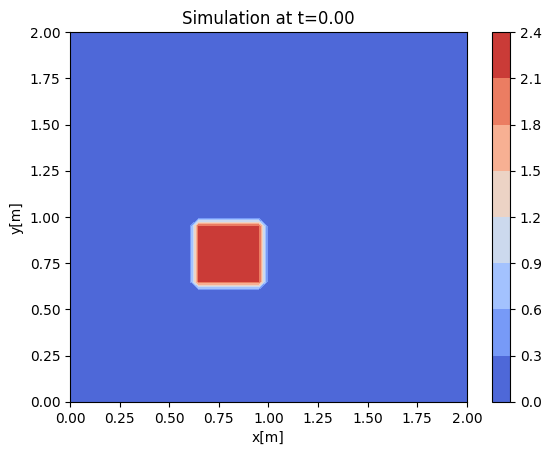

In [3]:
Lx = 2
Ly = 2
T = 0.1
v = 0.2
dx = 0.05
dy = 0.05
dt = 0.000225

#Creo el objeto string
surface = domain(Lx, Ly, T, v, dx, dy, dt)
print(surface)
surface.initialCond()

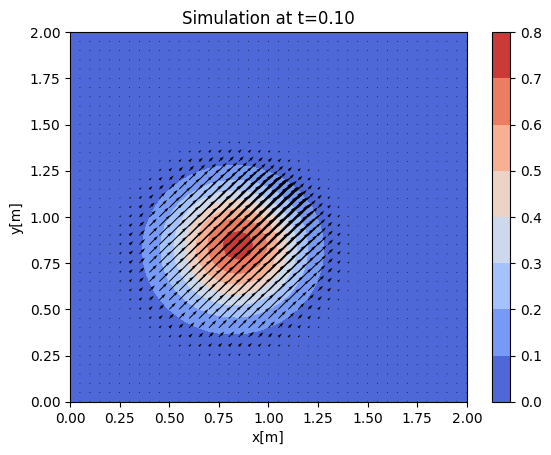

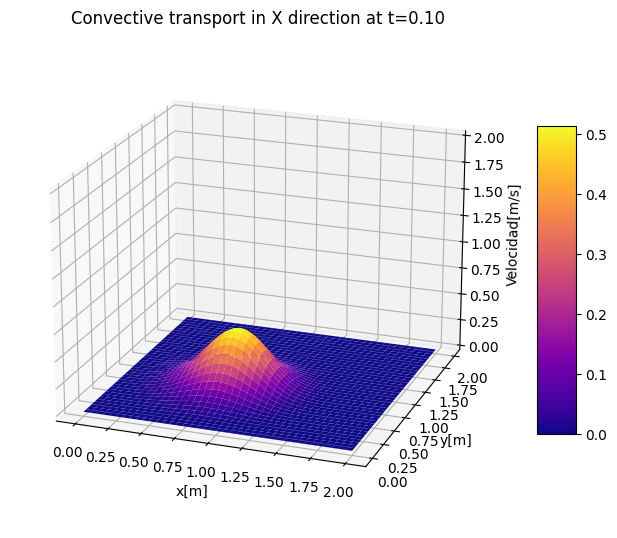

In [4]:
surface.solver()
surface.plotContour()
surface.plot3D()